## Quickstart

In this section, users will learn

1. the data input required to create a basic MMM
2. the fit and predict process of MMM
2. basic usage of the MMM

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import karpiu
from karpiu.models import MMM

pd.set_option("display.float_format", lambda x: "%.5f" % x)
pd.set_option("display.max_rows", 50)

print(karpiu.__version__)

0.0.1


In [2]:
%load_ext autoreload
%autoreload 2

### Data Input

In [3]:
RAW_DATA_FILE = "resource/seasonal/df.csv"
SCALABILITY_FILE = "resource/seasonal/scalability_df.csv"
paid_channels = ["promo", "radio", "search", "social", "tv"]

This is the core spend and response(the sales) input data.

In [12]:
df = pd.read_csv(RAW_DATA_FILE, parse_dates=["date"])

Note that the one-hot-encoded dummies are already appended in the dataframe.

In [29]:
event_cols = [
    "new-years-day",
    "martin-luther-king-jr-day",
    "washingtons-birthday",
    "memorial-day",
    "independence-day",
    "labor-day",
    "columbus-day",
    "veterans-day",
    "thanksgiving",
    "christmas-day",
    "independence-day-observed",
    "juneteenth-national-independence-day-observed",
    "juneteenth-national-independence-day",
    "christmas-day-observed",
    "new-years-day-observed",
]

In [24]:
df.head(5)

,date,sales,promo,radio,search,social,tv,new-years-day,martin-luther-king-jr-day,washingtons-birthday,...,labor-day,columbus-day,veterans-day,thanksgiving,christmas-day,independence-day-observed,juneteenth-national-independence-day-observed,juneteenth-national-independence-day,christmas-day-observed,new-years-day-observed
0,2019-01-01,631.00000,1070.00000,7319.00000,0.00000,2530.00000,8755.00000,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2019-01-02,397.00000,1926.00000,5729.00000,4189.00000,1635.00000,5621.00000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2019-01-03,530.00000,2224.00000,0.00000,4820.00000,0.00000,13586.00000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2019-01-04,766.00000,2405.00000,3163.00000,0.00000,0.00000,10953.00000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2019-01-05,1168.00000,2122.00000,8359.00000,2937.00000,0.00000,0.00000,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
scalability_df = pd.read_csv(SCALABILITY_FILE)
scalability_df.head(5)

,regressor,scalability
0,promo,3.00000
1,radio,1.25000
2,search,0.80000
3,social,1.30000
4,tv,1.50000


### Fitting a Basic MMM

In [26]:
mmm = MMM(
    kpi_col="sales",
    date_col="date",
    spend_cols=paid_channels,
    scalability_df=scalability_df,
    event_cols=event_cols,
    seed=2022,
    seasonality=[7, 365.25],
    fs_orders=[2, 3],
    events_sigma_prior=0.3,
)

2023-05-15 18:21:35 - karpiu-mmm - INFO - Initialize model


For now, users can skip the hyper-parameters fitting section and directly set some prepared hyper-parameters.

In [27]:
best_params = {
    "damped_factor": 0.949,
    "level_sm_input": 0.00245,
}
mmm.set_hyper_params(best_params)

2023-05-15 18:21:36 - karpiu-mmm - INFO - Set hyper-parameters.
2023-05-15 18:21:36 - karpiu-mmm - INFO - Best params damped_factor set as 0.94900
2023-05-15 18:21:36 - karpiu-mmm - INFO - Best params level_sm_input set as 0.00245


Fit the model with supplied dataframe.

<div class="alert alert-block alert-success"> <b>Tips:</b> Users can provide additional arg e.g. `chains=4` to perform sampling with multiple chains. </div>

In [28]:
mmm.fit(df, num_warmup=1000, num_sample=1000)

2023-05-15 18:21:37 - karpiu-mmm - INFO - Fit final model.
2023-05-15 18:21:37 - karpiu-mmm - INFO - Deriving saturation constants...
2023-05-15 18:21:37 - karpiu-mmm - INFO - Derived saturation constants.
2023-05-15 18:21:37 - karpiu-mmm - INFO - Build a default regression scheme
2023-05-15 18:21:37 - orbit - INFO - Sampling (PyStan) with chains: 1, cores: 8, temperature: 1.000, warmups (per chain): 1000 and samples(per chain): 1000.


chain 1 |          | 00:00 Status

2023-05-15 18:24:38 - karpiu-mmm - INFO - Spend channels regression coefficients sum (0.44208885) is within common range (0, 0.8].


### Extracting Insights from the Model

### Attribution

In [30]:
from karpiu.explainability import AttributorBeta

In [31]:
ATTR_START = "2019-03-01"
ATTR_END = "2019-03-31"
attributor = AttributorBeta(model=mmm, start=ATTR_START, end=ATTR_END)
activities_attr_df, spend_attr_df, spend_df, cost_df = attributor.make_attribution(
    fixed_intercept=False
)

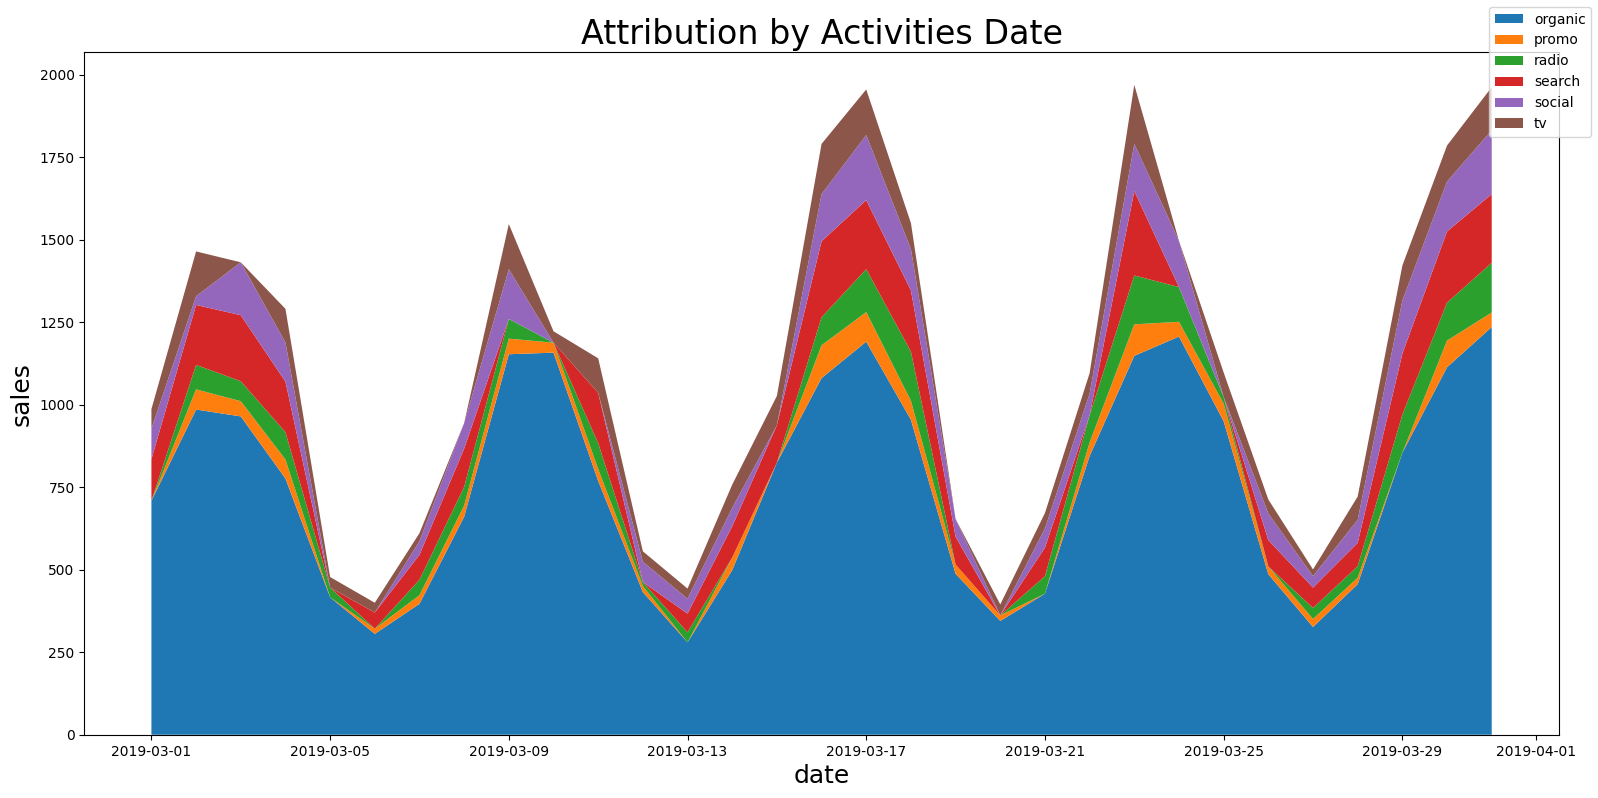

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.stackplot(
    activities_attr_df["date"].values,
    activities_attr_df[["organic"] + paid_channels].values.transpose(),
    labels=["organic"] + paid_channels,
)
ax.set_title("Attribution by Activities Date", fontdict={"fontsize": 24})
ax.set_xlabel("date", fontdict={"fontsize": 18})
ax.set_ylabel("sales", fontdict={"fontsize": 18})
fig.legend()
fig.tight_layout();

### Cost and Efficiency Analysis

In [33]:
from karpiu.planning.cost_curves import CostCurves

In [34]:
cc = CostCurves(
    model=mmm,
    curve_type="individual",
    n_steps=50,
    channels=paid_channels,
    spend_start=ATTR_START,
    spend_end=ATTR_END,
)
cc.generate_cost_curves()

  0%|          | 0/5 [00:00<?, ?it/s]

To prevent overflow, users can provide a scaler in plotting the cost curves.

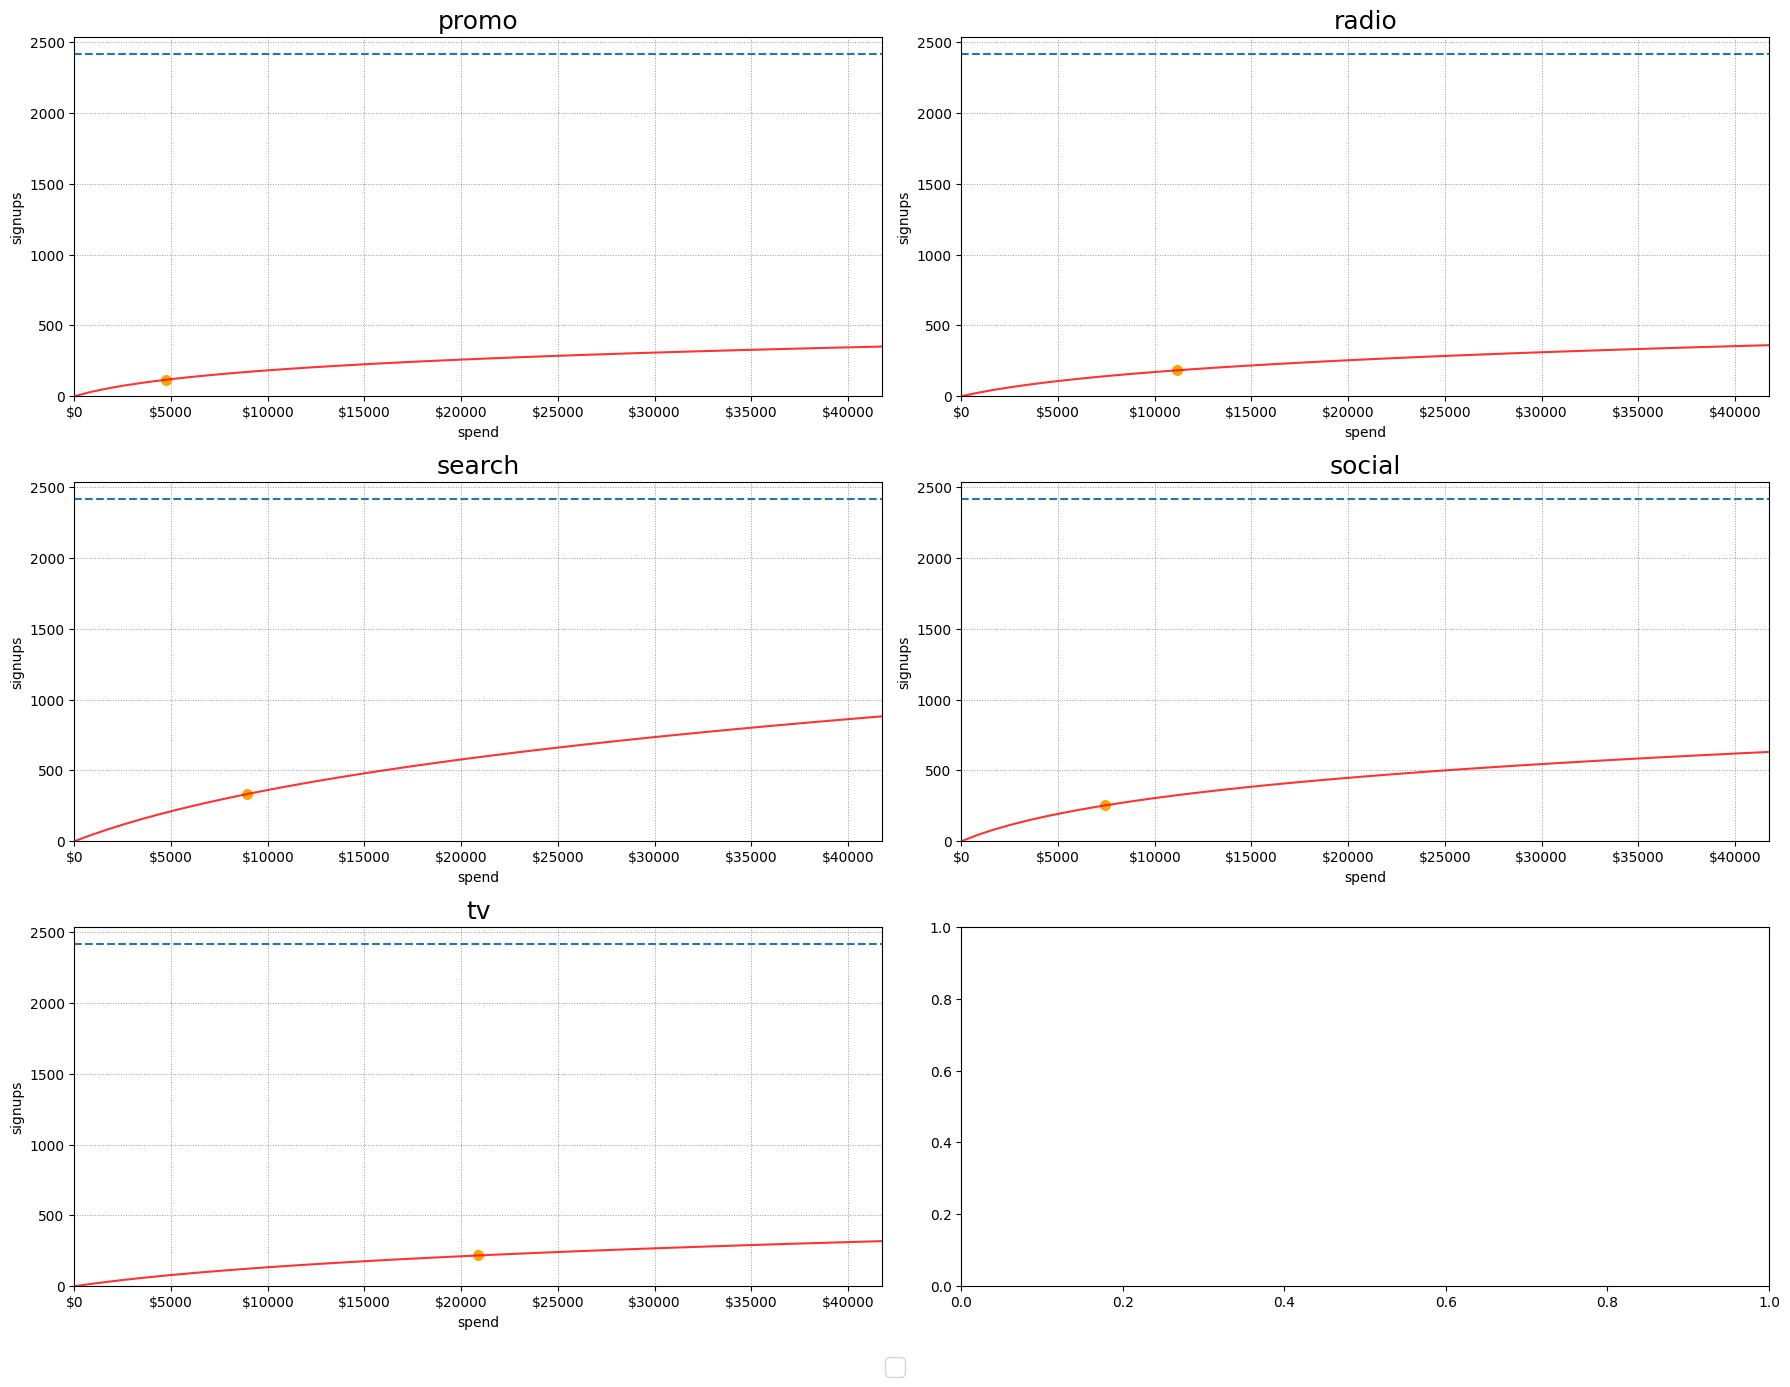

In [35]:
cc.plot(spend_scaler=10, outcome_scaler=10);

### Model Regression Coefficents

In [36]:
mmm.get_regression_summary()

,regressor,sign,coef_p50,coef_p05,coef_p95,Pr(coef >= 0),Pr(coef < 0),loc_prior,scale_prior
0,promo,Positive,0.04583,0.04006,0.05170,1.00000,0.00000,0.00000,0.10000
1,radio,Positive,0.06051,0.05616,0.06488,1.00000,0.00000,0.00000,0.10000
2,search,Positive,0.17444,0.16710,0.18166,1.00000,0.00000,0.00000,0.10000
3,social,Positive,0.09445,0.08907,0.09999,1.00000,0.00000,0.00000,0.10000
4,tv,Positive,0.06686,0.06233,0.07167,1.00000,0.00000,0.00000,0.10000
5,s7_fs_cos1,Regular,0.18136,0.17781,0.18502,1.00000,0.00000,0.00000,0.30000
6,s7_fs_cos2,Regular,0.10155,0.09786,0.10518,1.00000,0.00000,0.00000,0.30000
7,s7_fs_sin1,Regular,-0.62595,-0.62962,-0.62236,0.00000,1.00000,0.00000,0.30000
8,s7_fs_sin2,Regular,0.00593,0.00272,0.00937,0.99500,0.00500,0.00000,0.30000
9,s365.25_fs_cos1,Regular,-0.09979,-0.10726,-0.09273,0.00000,1.00000,0.00000,0.30000


### Forecast Future Outcome

Prediction interval is not supported yet but will be available in future version. Here a demo of using `insert_event` and `extend_ts_features` are also shown to generate future dataframe for long-term forecast checking.

In [43]:
from karpiu.utils import insert_events, extend_ts_features
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components

In [44]:
future_df = extend_ts_features(df, 365, date_col="date")
future_df, event_cols = insert_events(future_df, date_col="date", country="US")

In [45]:
pred_df = mmm.predict(future_df)

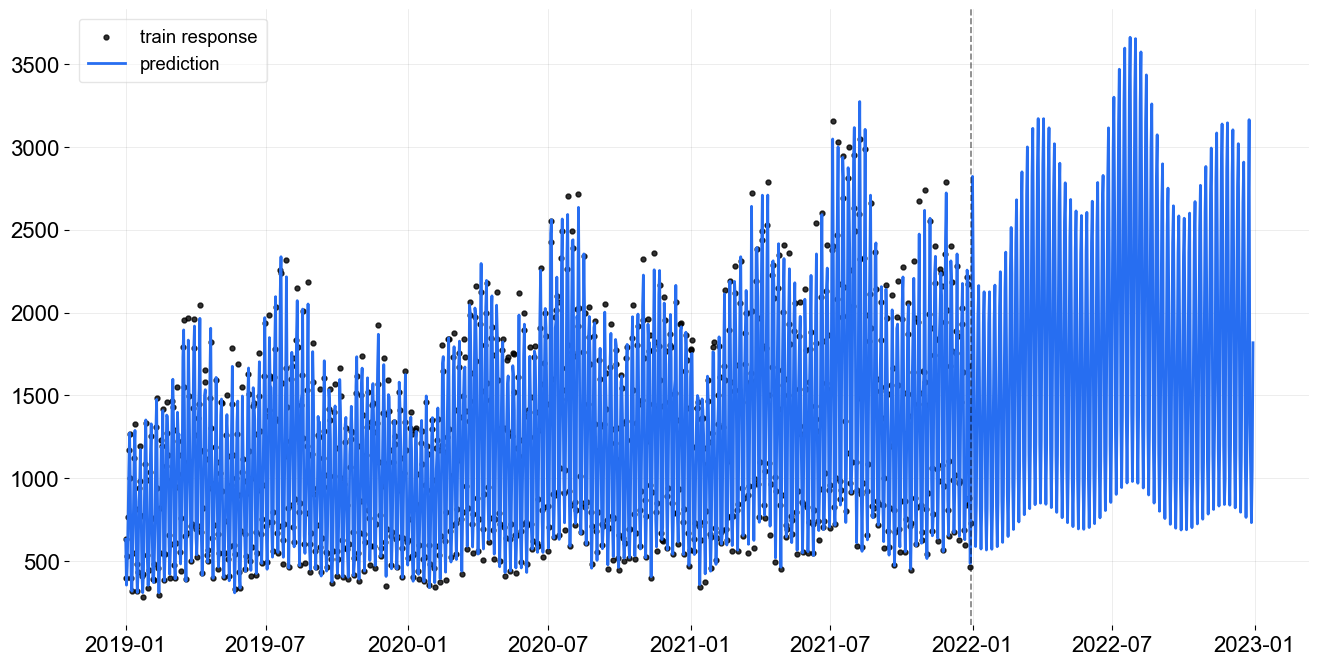

In [46]:
plot_predicted_data(
    training_actual_df=df,
    predicted_df=pred_df,
    date_col="date",
    actual_col="sales",
);

In [47]:
pred_df = mmm.predict(future_df, decompose=True)

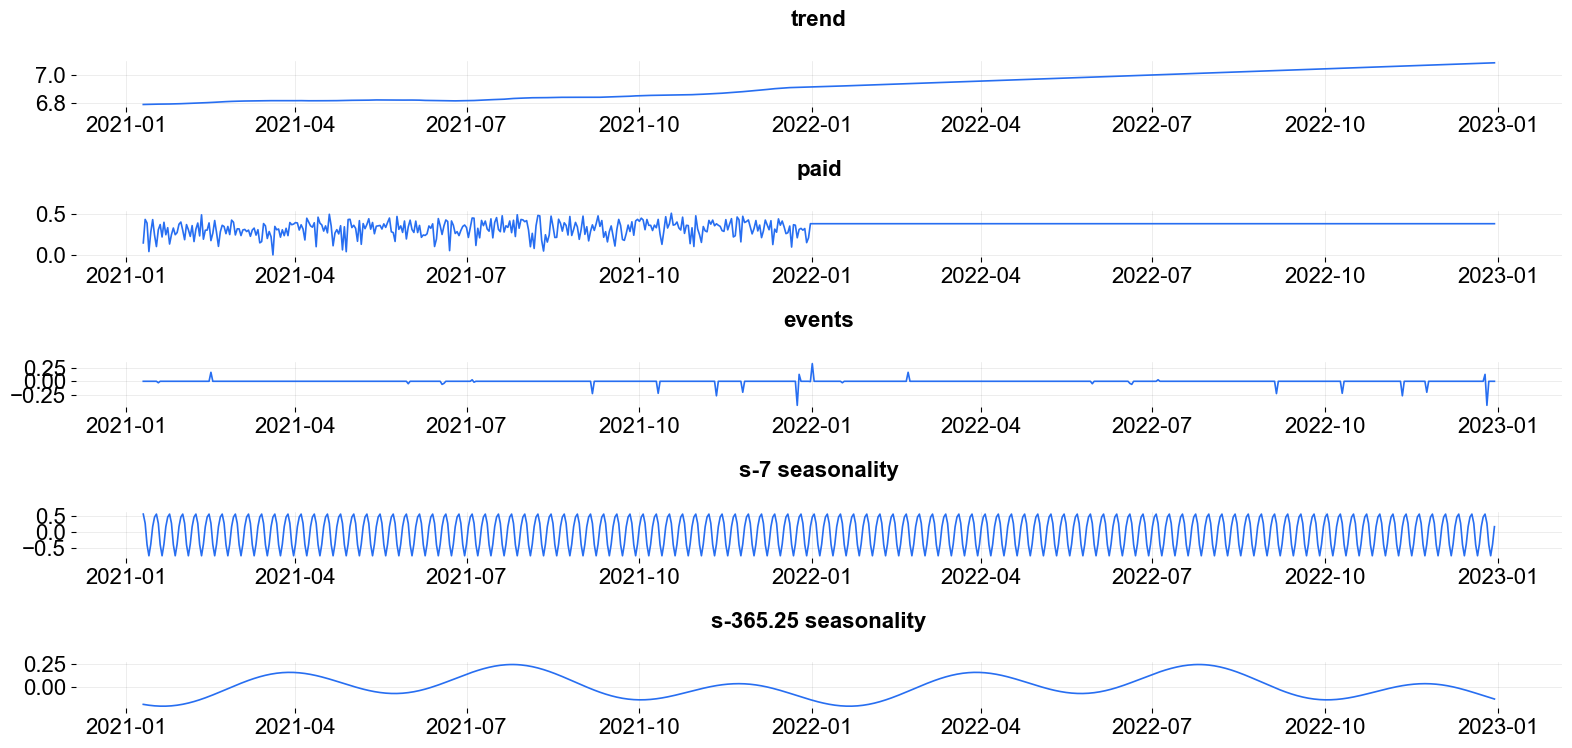

In [48]:
plot_predicted_components(
    predicted_df=pred_df[-720:],
    date_col="date",
    plot_components=[
        "trend",
        "paid",
        "events",
        "s-7 seasonality",
        "s-365.25 seasonality",
    ],
);

## Dump Model for Future Usage

In [50]:
import pickle

with open("./resource/seasonal/model.pkl", "wb") as f:
    pickle.dump(mmm, f, protocol=pickle.HIGHEST_PROTOCOL)